In [473]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Load Data and Preprocessing

In [474]:
# Keep only needed columns
feature_names = [
    "Age", "Workclass", "Education", 
    "Occupation", "Relationship", "Race", 
    "Sex", "Capital Gain", "Capital Loss", 
    "Hours per week", "Country", "label"
]

df = pd.DataFrame(
  np.genfromtxt('dataset/adult.csv', delimiter=', ', dtype=str, usecols=(0,1,3,6,7,8,9,10,11,12,13,14)),    
  columns=feature_names
)

# Drop missing values denoted as ?
cols = list(df.columns)
df[cols] = df[cols].replace(['?'], np.nan)
df = df.dropna()


# Declare categorical columns
categorical_columns=[
   "Workclass", "Education", "Occupation", "Relationship", "Race", "Sex", "Country", "label"
]

# Assign type to features
for feature in feature_names:
    if feature in categorical_columns:
        df[feature] = df[feature].astype("category")
    else:
        df[feature] = df[feature].astype("int")

# Make bins for age and hours per week
df['Age'] = pd.cut(df['Age'], bins=[16, 35 , 90],labels=['Young','Aged'])
df["Hours per week"] = pd.cut(
            x=df["Hours per week"],
            bins=[0.9, 25, 39, 40, 55, 100],
            labels=["PartTime", "MidTime", "FullTime", "OverTime", "BrainDrain"])

# Replace "Husband" and "Wife" values with the unisex "Married"
df["Relationship"] = df["Relationship"].replace('Husband','Married')
df["Relationship"] = df["Relationship"].replace('Wife','Married')

# Will have income >50k (1 or 0)
df["label"] = df["label"].replace('>50K',1)
df["label"] = df["label"].replace('<=50K',0)

df.sample(5)

,Age,Workclass,Education,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,label
2880,Young,Private,HS-grad,Handlers-cleaners,Other-relative,White,Male,0,0,FullTime,United-States,0
27864,Young,Private,11th,Other-service,Married,White,Female,0,0,BrainDrain,United-States,0
1461,Aged,Private,10th,Machine-op-inspct,Not-in-family,Black,Male,0,0,FullTime,United-States,0
8553,Young,Private,Assoc-voc,Other-service,Own-child,White,Female,0,0,PartTime,United-States,0
8454,Young,Private,Bachelors,Exec-managerial,Married,White,Female,0,0,FullTime,United-States,1


In [475]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30162 entries, 0 to 32560
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Age             30162 non-null  category
 1   Workclass       30162 non-null  category
 2   Education       30162 non-null  category
 3   Occupation      30162 non-null  category
 4   Relationship    30162 non-null  category
 5   Race            30162 non-null  category
 6   Sex             30162 non-null  category
 7   Capital Gain    30162 non-null  int64   
 8   Capital Loss    30162 non-null  int64   
 9   Hours per week  30162 non-null  category
 10  Country         30162 non-null  category
 11  label           30162 non-null  category
dtypes: category(10), int64(2)
memory usage: 1005.5 KB


## Model Creation

In [476]:
# Data preprocessing to train model
from omnixai.data.tabular import Tabular
from omnixai.preprocessing.tabular import TabularTransform
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

tabular_data = Tabular(
   df,
   categorical_columns=[
  "Age", "Workclass", "Education", "Occupation", "Relationship", "Race", "Sex", "Hours per week", "Country"
],
   target_column='label'
)
transformer = TabularTransform().fit(tabular_data)
class_names = transformer.class_names
x = transformer.transform(tabular_data)

# Split data into training and (validation + test) datasets
train, X_temp, train_labels, y_temp  = \
    train_test_split(x[:, :-1], x[:, -1], train_size=0.70, random_state = 123)

# Split data validation and test sets
val, test, val_labels, test_labels = train_test_split(X_temp, y_temp, test_size=0.5, random_state=123)

test_labels = test_labels.astype(int)

print('Training data shape:   {}'.format(train.shape))
print('Validation data shape:  {}'.format(val.shape))
print('Test data shape:        {}'.format(test.shape))

# Train a Random Forest model
model = RandomForestClassifier(random_state=123)
model.fit(train, train_labels)

predict_function=lambda z: model.predict_proba(transformer.transform(z))

# Convert the transformed data back to Tabular instances
train_data = transformer.invert(train)
test_data = transformer.invert(test)

display(tabular_data.target_column)
display(train_labels[:2])

Training data shape:   (21113, 99)
Validation data shape:  (4524, 99)
Test data shape:        (4525, 99)


'label'

array([1., 0.])

In [477]:
# Model Predictions
test_df = test_data.to_pd()
test_df["label"] = test_labels
predictions = model.predict(test)
test_df["prediction"] = predictions

test_df.sample(5)

,Age,Workclass,Education,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,label,prediction
2959,Young,Private,Masters,Prof-specialty,Not-in-family,White,Female,0.0,0.0,OverTime,United-States,0,0.0
3401,Aged,Private,Assoc-acdm,Tech-support,Not-in-family,White,Female,0.0,0.0,FullTime,United-States,0,0.0
334,Aged,Private,Some-college,Prof-specialty,Married,White,Male,0.0,0.0,FullTime,United-States,0,0.0
1650,Aged,State-gov,Some-college,Farming-fishing,Married,White,Male,0.0,0.0,OverTime,United-States,0,0.0
3998,Young,Local-gov,Bachelors,Protective-serv,Married,White,Male,0.0,0.0,BrainDrain,United-States,1,1.0


Test: accuracy=0.8513
Test: TP=734, TN=3118, FP=263, FN=410


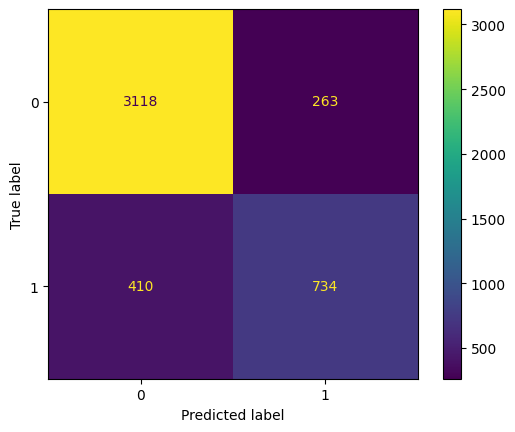

In [478]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

accuracy = accuracy_score(test_labels, predictions)
print(f'Test: {accuracy=:.4f}')

cm = confusion_matrix(test_labels, predictions)

TN = cm[0][0]
FN = cm[1][0]
TP = cm[1][1]
FP = cm[0][1]
print(f"Test: {TP=}, {TN=}, {FP=}, {FN=}")

disp = ConfusionMatrixDisplay(confusion_matrix=cm, )
disp.plot()

## Fairness
Now the fairness will be analyzed

First we import the necessary libraries

In [479]:
import warnings
# Suppress warnings
warnings.filterwarnings("ignore")

from aif360.datasets import BinaryLabelDataset
from aif360.algorithms.preprocessing import Reweighing
import random
from aif360.metrics import ClassificationMetric

Since for the fairness analysis, we can not use the Tabular data, we create a new dataframe with the transformed values of TabularTransform. This is because we need to have access to a dataframe structure containing the binarized values (for age, sex and all categorical attributes) and not the categorical values (e.g. Young/Aged, Female/Male etc.)

In [480]:
column_names = transformer.get_feature_names()
# Last column is the label which is not included in the get_feature_names
column_names.append('label')

fairness_dataset = pd.DataFrame(x, columns=column_names)
fairness_dataset.head(3)

,Age_Aged,Age_Young,Workclass_Federal-gov,Workclass_Local-gov,Workclass_Private,Workclass_Self-emp-inc,Workclass_Self-emp-not-inc,Workclass_State-gov,Workclass_Without-pay,Education_10th,...,Country_South,Country_Taiwan,Country_Thailand,Country_Trinadad&Tobago,Country_United-States,Country_Vietnam,Country_Yugoslavia,Capital Gain,Capital Loss,label
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2174.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


As seen below there are four columns for the protected attributes of sex and age. Two boolean columns for each:

In [481]:
fairness_dataset[['Age_Aged', 'Age_Young', 'Sex_Male', 'Sex_Female']].head(3)

,Age_Aged,Age_Young,Sex_Male,Sex_Female
0,1.0,0.0,1.0,0.0
1,1.0,0.0,1.0,0.0
2,1.0,0.0,1.0,0.0


We decide only to keep `Age_Aged` and `Sex_Male`, and renaming those to columns to `Age` and `Sex` meaning that:
- when `Sex` is 0, the person is female and when when `Sex` is 1, the person is male
- when `Age` is 0, the person is young and  when `Age` is 0, the person is aged


In [482]:
fairness_dataset = fairness_dataset.drop(columns=['Age_Young', 'Sex_Female'])
fairness_dataset.rename(columns={'Age_Aged': 'Age', 'Sex_Male': 'Sex'}, inplace=True)

Next we want to ensure that we train the classifier on the exact same data as the previous normal classifier, keeping the train, validation and test split:

In [483]:
# Split data into training and (validation + test) datasets
train, X_temp, _, y_temp  = \
    train_test_split(fairness_dataset, fairness_dataset.label, train_size=0.70, random_state = 123)

# Split data validation and test sets
val, test, _, _ = train_test_split(X_temp, y_temp, test_size=0.5, random_state=123)

Now we can transform the previous data structures into BinaryLabelDatasets:

In [484]:
# Transform to BinaryLabelDataset
dataset_fair_train = BinaryLabelDataset(df=train, label_names=['label'], protected_attribute_names=['Age', 'Sex'])
dataset_fair_valid = BinaryLabelDataset(df=val, label_names=['label'], protected_attribute_names=['Age', 'Sex'])
dataset_fair_test = BinaryLabelDataset(df=test, label_names=['label'], protected_attribute_names=['Age', 'Sex'])

Now the group fairness of the classifier will be assessed, assuming the protected attributes are Age, Sex.

We assume that:
- Young age (corresponding to 0) is one unprivileged group and Aged (corresponding to 1) is one privileged group
- Female sex is one unprivileged (corresponding to 0) group and male sex (corresponding to 1) is one privileged group:

In [485]:
privileged_groups = [{'Age':1,
                      'Sex':1}]
unprivileged_groups = [{'Age': 0,
                       'Sex':0}]

Since there is a significant difference in the positive rates and true positive rate thus there is unfairness. Actually, the priviliged groups (aged and male) has 37% more chance to be predicted as >50k income comparing to the unprivileged group (young, female)

Now, we will try to mitigate this bias in the training dataset by using the `Reweighing algorithm`. By reweighing we ensure that there is better fairness when we compare the positive rates between privileged and unprivileged groups

In [486]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
dataset_transf_train = RW.fit_transform(dataset_fair_train)

### Fair classifier

Since reweighting does not achieve the goal of $0$ statistical parity difference or Equal opportunity difference, we will oversample the underprivileged classes (female young) and undersample the privileged classes (male aged) to teach the classifier to be more fair. After some experimentation, it was decided:
- $750$ extra samples of young female with income >50k were randomly oversampled in the training data, and random weights of values between $[1.2,1.6]$ were given for each sample
- $1500$ samples of aged male with income >50k were randomly undersampled in the training data (completely removed from the training set)

In [487]:
# Seed to reproduce results
random.seed(1)

# Number of over-samples produced for training dataset
number_oversamples = 750
# Number of under-samples to be removed for training dataset
number_undersamples = 1500

# Train and target data
X_train = dataset_transf_train.features
y_train = dataset_transf_train.labels.ravel()

# Resampled data structures
X_train_resampled = X_train.copy()
y_train_resampled = y_train.copy()
weights_resampled = dataset_transf_train.instance_weights.copy()

# list to keep for indexes of undersamples (to be deleted after)
list_indexes_undersamples = []
# List to keep the over_samples and counters of oversamples and undersamples
oversamples = []
counter_oversamples = 0
counter_undersamples = 0

# Iterate over the whole training dataset
for counter in range(len(X_train)):
    # Only append rows that contain young female since this is the heavily underprivileged class
    if (X_train[counter][0] == 0) and (X_train[counter][1] == 0) and (y_train[counter] == 1)\
        and (counter_oversamples < number_oversamples):
        oversamples.append(X_train[counter].copy())
        counter_oversamples += 1
    # Store index of rows that contain aged male since this is the heavily overprivileged class
    if ((X_train[counter][0] == 1) or (X_train[counter][1] == 1)) and (y_train[counter] == 1)\
        and (counter_undersamples < number_undersamples):
        list_indexes_undersamples.append(counter)
        counter_undersamples += 1
    # When number of extra oversamples and undersamples is reached, stop loop
    if (counter_oversamples == number_oversamples) and (counter_undersamples == number_undersamples):
        break
    counter += 1

# Remove all indexes of undersamples
X_train_resampled = np.delete(X_train_resampled, list_indexes_undersamples, axis=0)
y_train_resampled = np.delete(y_train_resampled, list_indexes_undersamples)
weights_resampled = np.delete(weights_resampled, list_indexes_undersamples)


# Only assign positive labels to favor underprivileged class 
arr = np.array([1 for i in range(number_oversamples)])

# Append extra samples and labels to the training data and 
y_train_resampled = np.append(y_train_resampled, arr)
X_train_resampled = np.vstack([X_train_resampled, oversamples])
# Randomize weights of extra samples to take values between 1 and 1.5
weights_resampled = np.append(weights_resampled, np.array([random.uniform(1.2, 1.6) for i in range(number_oversamples)]))

Now we can train the classifier:

In [488]:
model_fair_reweighted = RandomForestClassifier(random_state=123)
model_fair_reweighted.fit(X_train_resampled, y_train_resampled, sample_weight=weights_resampled)

X_test = dataset_fair_test.features
y_test = dataset_fair_test.labels

Next predict the test data <b> based on the threshold </b> found in the fairness analysis:

In [489]:
predictions = []
threshold_fairness = 0.4555
# positive class index
pos_ind = 1

for item in model_fair_reweighted.predict_proba(X_test)[:,pos_ind].reshape(-1,1):
    if item >=  threshold_fairness:
        predictions.append(1)
    else:
        predictions.append(0)

Last let's print the metrics for this classifier:

Test: accuracy_fair=0.8296
Test: TP=633, TN=3121, FP=260, FN=511


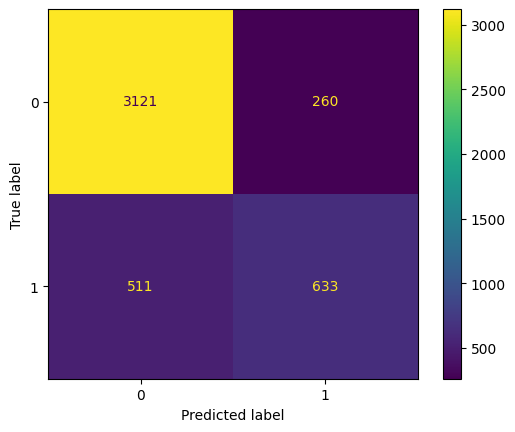

In [490]:
accuracy_fair = accuracy_score(y_test, predictions)
print(f'Test: {accuracy_fair=:.4f}')

cm = confusion_matrix(y_test, predictions)

TN = cm[0][0]
FN = cm[1][0]
TP = cm[1][1]
FP = cm[0][1]
print(f"Test: {TP=}, {TN=}, {FP=}, {FN=}")

disp = ConfusionMatrixDisplay(confusion_matrix=cm, )
disp.plot()

Also the fairness metric of `equal opportunity difference` will be printed for the fair classifier:

In [491]:
# Preparation of predictions dateset - transform into BinaryLabelDataset with right predictions based on the fairness threshold
dataset_fair_test_pred = dataset_fair_test.copy(deepcopy=True)
dataset_fair_test_pred.scores = model_fair_reweighted.predict_proba(X_test)[:,pos_ind].reshape(-1,1)
fav_inds = dataset_fair_test_pred.scores > threshold_fairness
dataset_fair_test_pred.labels[fav_inds] = dataset_fair_test_pred.favorable_label
dataset_fair_test_pred.labels[~fav_inds] = dataset_fair_test_pred.unfavorable_label

# Calculate metric
equal_opportunity_diff_metric = ClassificationMetric(dataset_fair_test, dataset_fair_test_pred, 
                                            unprivileged_groups=unprivileged_groups,
                                            privileged_groups=privileged_groups).equal_opportunity_difference()
print(f'Equal opportunity difference: {equal_opportunity_diff_metric=:.4f}')

Equal opportunity difference: equal_opportunity_diff_metric=0.0202


## Privacy

To start off, let's define a new dataframe similar to the one above, the set the values of p and q for both sensitive attributes and compute for epsilon. For now, both attributes are assumed to have the same p and q, but they can be redefined to any value as seen fit. We computed the appropriate p and q to get an epsilon = 2.

Random response is applied to the relevant attributes afterwards.

In [492]:
import random
import math
random.seed(123)  # Set the random seed for reproducibility

# randomized response 
def rand_resp(x, p=0.75, q=0.75):
    toss = random.random()
    if x == 0:
        y = 0 if toss <= q else 1
    else:
        y = 1 if toss <= p else 0
    return y

def get_epsilon(p=0.75, q=0.75):
    return math.log( max(q/(1-p), p/(1-q)) )

# apply attribute to a attribute
def privatize_attribute(column, true_label, false_label, p, q):
    # Convert labels to binary values
    binary_values = column.apply(lambda x: 1 if x == true_label else 0).values
    
    # Apply randomized response
    privatized_values = pd.Series([rand_resp(x, p, q) for x in binary_values], index=column.index)

    # Convert back to original labels
    return privatized_values.apply(lambda x: true_label if x == 1 else false_label)

# Create a copy of the original data
df_private = df.copy(deep=True)

# Set values of p and q
p, q = 0.7310585786300049, 0.7310585786300049

epsilon = get_epsilon(p, q)
print(f"We will apply {epsilon:.3f}-LDP setting p={p}, q={q} for both age and sex.")

# Apply randomized response to Age and Sex
df_private['Age'] = privatize_attribute(df_private['Age'], 'Aged', 'Young', p, q)
df_private['Sex'] = privatize_attribute(df_private['Sex'], 'Male', 'Female', p, q)

# Display the new DataFrame
df_private.head()

We will apply 1.000-LDP setting p=0.7310585786300049, q=0.7310585786300049 for both age and sex.


,Age,Workclass,Education,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,label
0,Aged,State-gov,Bachelors,Adm-clerical,Not-in-family,White,Male,2174,0,FullTime,United-States,0
1,Aged,Self-emp-not-inc,Bachelors,Exec-managerial,Married,White,Male,0,0,PartTime,United-States,0
2,Aged,Private,HS-grad,Handlers-cleaners,Not-in-family,White,Male,0,0,FullTime,United-States,0
3,Aged,Private,11th,Handlers-cleaners,Married,Black,Male,0,0,FullTime,United-States,0
4,Aged,Private,Bachelors,Prof-specialty,Married,Black,Female,0,0,FullTime,Cuba,0


We compute the cross-tabulation on the original data and private data to estimate how many people exist in value combinations of the two sensitive attributes.

In [493]:
from tabulate import tabulate

# Showing cross tabulation
print("\nOriginal Cross-tabulation:")
original_crosstab = pd.crosstab(df['Age'], df['Sex'])
print(tabulate(original_crosstab, headers='keys', tablefmt='pretty'))

print("\nPrivatized Cross-tabulation:")
privatized_crosstab = pd.crosstab(df_private['Age'], df_private['Sex'])
print(tabulate(privatized_crosstab, headers='keys', tablefmt='pretty'))


Original Cross-tabulation:
+-------+--------+-------+
|  Age  | Female | Male  |
+-------+--------+-------+
| Young |  4960  | 8778  |
| Aged  |  4822  | 11602 |
+-------+--------+-------+

Privatized Cross-tabulation:
+-------+--------+------+
|  Age  | Female | Male |
+-------+--------+------+
| Aged  |  6528  | 9154 |
| Young |  6229  | 8251 |
+-------+--------+------+


Compute the error between the privatized and the original data.

In [494]:
def pct_error(true_value, estimated_value):

    if true_value == 0:
        # If the true value is zero, the percent error is undefined.
        return float('inf')
    
    # Calculate the absolute difference
    abs_error = abs(true_value - estimated_value)
        
    # Calculate the percent error
    pct_error = (abs_error / true_value) * 100
        
    return pct_error

print("\nError Crosstab:")
print(tabulate(original_crosstab - privatized_crosstab, headers='keys', tablefmt='pretty'))

error_female_young = pct_error(original_crosstab["Female"]["Young"], privatized_crosstab["Female"]["Young"])
print(f"\nThe percent error for young female responses is: {error_female_young}%")

error_female_aged = pct_error(original_crosstab["Female"]["Aged"], privatized_crosstab["Female"]["Aged"])
print(f"The percent error for aged female responses is: {error_female_aged}%")

error_male_young = pct_error(original_crosstab["Male"]["Young"], privatized_crosstab["Male"]["Young"])
print(f"The percent error for young male responses is: {error_male_young}%")

error_male_aged = pct_error(original_crosstab["Male"]["Aged"], privatized_crosstab["Male"]["Aged"])
print(f"The percent error for aged male responses is: {error_male_aged}%")


Error Crosstab:
+-------+--------+------+
|  Age  | Female | Male |
+-------+--------+------+
| Aged  | -1706  | 2448 |
| Young | -1269  | 527  |
+-------+--------+------+

The percent error for young female responses is: 25.58467741935484%
The percent error for aged female responses is: 35.37951057652427%
The percent error for young male responses is: 6.003645477329688%
The percent error for aged male responses is: 21.099810377521116%


In [495]:
# Implement Private Classifier

tabular_data_private = Tabular(
   df_private,
   categorical_columns=[
  "Age", "Workclass", "Education", "Occupation", "Relationship", "Race", "Sex", "Hours per week", "Country"
],
   target_column='label'
)
transformer_private = TabularTransform().fit(tabular_data_private)
class_names = transformer_private.class_names
x_private = transformer_private.transform(tabular_data_private)

# Split data into training and (validation + test) datasets
train_private, X_private_temp, train_labels_private, y_private_temp  = \
    train_test_split(x_private[:, :-1], x_private[:, -1], train_size=0.70, random_state = 123)

# Split data validation and test sets
val_private, test_private, val_labels_private, test_labels_private = train_test_split(X_private_temp, y_private_temp, test_size=0.5, random_state=123)

test_labels_private = test_labels_private.astype(int)

print('Private Classfier')
print('Training data shape:   {}'.format(train_private.shape))
print('Validation data shape:  {}'.format(val_private.shape))
print('Test data shape:        {}'.format(test_private.shape))

# Train a Random Forest model
model_private = RandomForestClassifier(random_state=123)
model_private.fit(train_private, train_labels_private)

predict_function_private=lambda z: model_private.predict_proba(transformer_private.transform(z))

# # Convert the transformed data back to Tabular instances
train_data_private = transformer_private.invert(train_private)
test_data_private = transformer_private.invert(test_private)

display(tabular_data_private.target_column)
display(train_labels_private[:2])

Private Classfier
Training data shape:   (21113, 99)
Validation data shape:  (4524, 99)
Test data shape:        (4525, 99)


'label'

array([1., 0.])

In [496]:
# Model Predictions
test_df_private = test_data_private.to_pd()
test_df_private["label"] = test_labels_private
predictions_private = model_private.predict(test_private)
test_df_private["prediction"] = predictions_private

test_df_private.sample(5)

,Age,Workclass,Education,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,label,prediction
284,Aged,Self-emp-not-inc,HS-grad,Craft-repair,Married,White,Female,0.0,0.0,OverTime,United-States,0,1.0
2856,Young,Private,HS-grad,Other-service,Not-in-family,White,Female,0.0,0.0,PartTime,United-States,0,0.0
711,Aged,Private,1st-4th,Transport-moving,Married,White,Male,0.0,0.0,OverTime,United-States,0,0.0
2784,Aged,Private,HS-grad,Farming-fishing,Unmarried,White,Male,0.0,0.0,FullTime,United-States,0,0.0
1827,Young,Private,Some-college,Transport-moving,Not-in-family,White,Female,0.0,0.0,PartTime,United-States,0,0.0


Test: accuracy_private=0.8420
Test: TP=718, TN=3092, FP=289, FN=426


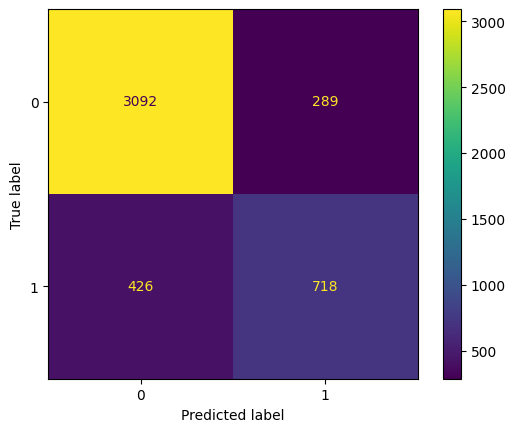

In [497]:
accuracy_private = accuracy_score(test_labels_private, predictions_private)
print(f'Test: {accuracy_private=:.4f}')

cm_private = confusion_matrix(test_labels_private, predictions_private)

TN = cm_private[0][0]
FN = cm_private[1][0]
TP = cm_private[1][1]
FP = cm_private[0][1]
print(f"Test: {TP=}, {TN=}, {FP=}, {FN=}")

disp = ConfusionMatrixDisplay(confusion_matrix=cm_private, )
disp.plot()

Implementing differential privacy involves adding noise to the training process to protect individual data points at the expense of degrading the model's accuracy. Lower epsilon values correspond to stronger privacy guarantees but also result in greater noise, which can lead to decreased model performance.

### Fairness of the Private Classifier

In [498]:
np.random.seed(123)
random.seed(123)

# Step 1: Assign feature names and create DataFrame
column_names_pf = transformer_private.get_feature_names()
column_names_pf.append('label')  # Add the label column
privatized_data_fair = pd.DataFrame(x_private, columns=column_names_pf)
privatized_data_fair.head(3)

,Age_Aged,Age_Young,Workclass_Federal-gov,Workclass_Local-gov,Workclass_Private,Workclass_Self-emp-inc,Workclass_Self-emp-not-inc,Workclass_State-gov,Workclass_Without-pay,Education_10th,...,Country_South,Country_Taiwan,Country_Thailand,Country_Trinadad&Tobago,Country_United-States,Country_Vietnam,Country_Yugoslavia,Capital Gain,Capital Loss,label
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2174.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [499]:
privatized_data_fair = privatized_data_fair.drop(columns=['Age_Young', 'Sex_Female'])
privatized_data_fair.rename(columns={'Age_Aged': 'Age', 'Sex_Male': 'Sex'}, inplace=True)

In [500]:
# Split into train, validation, and test sets
train_priv, X_temp_priv, _, y_temp_priv = train_test_split(
    privatized_data_fair, privatized_data_fair.label, train_size=0.70, random_state=123
)
val_priv, test_priv, _, _ = train_test_split(X_temp_priv, y_temp_priv, test_size=0.5, random_state=123)

In [501]:
# Create BinaryLabelDataset for privatized data
dataset_priv_train = BinaryLabelDataset(
    df=train_priv, label_names=['label'], protected_attribute_names=['Age', 'Sex']
)
dataset_priv_valid = BinaryLabelDataset(
    df=val_priv, label_names=['label'], protected_attribute_names=['Age', 'Sex']
)
dataset_priv_test = BinaryLabelDataset(
    df=test_priv, label_names=['label'], protected_attribute_names=['Age', 'Sex']
)

X_train_priv = dataset_priv_train.features
y_train_priv = dataset_priv_train.labels.ravel()
weights_priv = dataset_priv_train.instance_weights.copy()

In [502]:
# Train a Random Forest model
model_priv_fair = RandomForestClassifier(random_state=123)
model_priv_fair.fit(X_train_priv, y_train_priv, sample_weight=weights_priv)

# Test data
X_test_priv = dataset_priv_test.features
y_test_priv = dataset_priv_test.labels

# Predictions
predictions_priv_fair = []
threshold_priv_fair = 0.4555  # Example threshold
pos_ind = 1  # Positive class index

for prob in model_priv_fair.predict_proba(X_test_priv)[:, pos_ind]:
    predictions_priv_fair.append(1 if prob >= threshold_priv_fair else 0)

In [503]:
dataset_transf_test_pred = dataset_priv_test.copy(deepcopy=True)
X_test = dataset_transf_test_pred.features
y_test = dataset_transf_test_pred.labels
dataset_transf_test_pred.scores = model_priv_fair.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

In [ ]:
dataset_fair_valid_pred = dataset_priv_valid.copy(deepcopy=True)
X_valid = dataset_priv_valid.features
y_valid = dataset_priv_valid.labels
dataset_fair_valid_pred.scores = model_priv_fair.predict_proba(X_valid)[:,pos_ind].reshape(-1,1)


num_thresh = 100
ba_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)
for idx, class_thresh in enumerate(class_thresh_arr):
    
    fav_inds = dataset_fair_valid_pred.scores > class_thresh
    dataset_fair_valid_pred.labels[fav_inds] = dataset_fair_valid_pred.favorable_label
    dataset_fair_valid_pred.labels[~fav_inds] = dataset_fair_valid_pred.unfavorable_label
    
    classified_metric_orig_valid = ClassificationMetric(dataset_priv_valid,
                                             dataset_fair_valid_pred, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
    # Metric we wish to maximize
    ba_arr[idx] = classified_metric_orig_valid.accuracy()
    #ba_arr[idx] = 0.5*(classified_metric_orig_valid.true_positive_rate() + classified_metric_orig_valid.true_negative_rate())

best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
best_class_thresh = class_thresh_arr[best_ind]

print("Best Normal accuracy (no reweighing) = %.4f" % np.max(ba_arr))
print("Optimal classification threshold (no reweighing) = %.4f" % best_class_thresh)

Best Normal accuracy (no reweighing) = 0.8501
Optimal classification threshold (no reweighing) = 0.5247


In [505]:
import sys
import os
# setting path to import common_utils file found inside utils folder
sys.path.append(os.path.abspath('./utils'))

from common_utils import compute_metrics
from tqdm import tqdm

print(" Predictions from transformed testing data")
bal_acc_arr_transf = []
eq_opp_diff_tranf = []

print("Classification threshold used = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr):
    
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    
    fav_inds = dataset_transf_test_pred.scores > thresh
    dataset_transf_test_pred.labels[fav_inds] = dataset_transf_test_pred.favorable_label
    dataset_transf_test_pred.labels[~fav_inds] = dataset_transf_test_pred.unfavorable_label
    
    metric_test_aft = compute_metrics(dataset_priv_test, dataset_transf_test_pred, 
                                      unprivileged_groups, privileged_groups,
                                      disp = disp)

    bal_acc_arr_transf.append(metric_test_aft["Normal accuracy"])
    eq_opp_diff_tranf.append(metric_test_aft["Equal opportunity difference"])

 Predictions from transformed testing data
Classification threshold used = 0.5247


100%|██████████| 100/100 [00:00<00:00, 610.39it/s]

Balanced accuracy = 0.7650
Normal accuracy = 0.8424
Statistical parity difference = -0.1655
Disparate impact = 0.4477
Average odds difference = -0.0413
Equal opportunity difference = -0.0149
Theil index = 0.1259


## Privacy and Fairness
Now a fair version of the private classifier will be analyzed

We use the private data set from earlier and transform it to be compatible with the fairness classifier

In [ ]:
np.random.seed(123)
random.seed(123)

# Step 1: Assign feature names and create DataFrame
column_names_pf = transformer_private.get_feature_names()
column_names_pf.append('label')  # Add the label column
privatized_data_fair = pd.DataFrame(x, columns=column_names_pf)
privatized_data_fair.head(3)

,Age_Aged,Age_Young,Workclass_Federal-gov,Workclass_Local-gov,Workclass_Private,Workclass_Self-emp-inc,Workclass_Self-emp-not-inc,Workclass_State-gov,Workclass_Without-pay,Education_10th,...,Country_South,Country_Taiwan,Country_Thailand,Country_Trinadad&Tobago,Country_United-States,Country_Vietnam,Country_Yugoslavia,Capital Gain,Capital Loss,label
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2174.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [534]:
privatized_data_fair[['Age_Aged', 'Age_Young', 'Sex_Male', 'Sex_Female']].head(3)

,Age_Aged,Age_Young,Sex_Male,Sex_Female
0,1.0,0.0,1.0,0.0
1,1.0,0.0,1.0,0.0
2,1.0,0.0,1.0,0.0


In [535]:
privatized_data_fair = privatized_data_fair.drop(columns=['Age_Young', 'Sex_Female'])
privatized_data_fair.rename(columns={'Age_Aged': 'Age', 'Sex_Male': 'Sex'}, inplace=True)

In [536]:
# Split into train, validation, and test sets
train_priv, X_temp_priv, _, y_temp_priv = train_test_split(
    privatized_data_fair, privatized_data_fair.label, train_size=0.70, random_state=123
)
val_priv, test_priv, _, _ = train_test_split(X_temp_priv, y_temp_priv, test_size=0.5, random_state=123)

In [537]:
# Create BinaryLabelDataset for privatized data
dataset_priv_train = BinaryLabelDataset(
    df=train_priv, label_names=['label'], protected_attribute_names=['Age', 'Sex']
)
dataset_priv_valid = BinaryLabelDataset(
    df=val_priv, label_names=['label'], protected_attribute_names=['Age', 'Sex']
)
dataset_priv_test = BinaryLabelDataset(
    df=test_priv, label_names=['label'], protected_attribute_names=['Age', 'Sex']
)

### Reweighing
Use the Reweighing technique on the privatized dataset to adjust for fairness.

In [538]:
privileged_groups = [{'Age':1,
                      'Sex':1}]
unprivileged_groups = [{'Age': 0,
                       'Sex':0}]
# Apply Reweighing
RW_priv = Reweighing(
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)
dataset_transf_priv_train = RW_priv.fit_transform(dataset_priv_train)

### Resampling
Resample the data to correct for underprivileged and overprivileged classes.

In [539]:
# Train and target data
X_train_priv = dataset_transf_priv_train.features
y_train_priv = dataset_transf_priv_train.labels.ravel()
weights_priv = dataset_transf_priv_train.instance_weights.copy()

# Resampling parameters
number_oversamples = 750
number_undersamples = 1500

# Resampling logic (use the same logic from Part 2)
oversamples_priv = []
undersamples_indexes_priv = []
counter_oversamples_priv = 0
counter_undersamples_priv = 0

for i in range(len(X_train_priv)):
    # Over-sample underprivileged group (Young Female, 0,0)
    if (X_train_priv[i][0] == 0) and (X_train_priv[i][1] == 0) and (y_train_priv[i] == 1) \
            and counter_oversamples_priv < number_oversamples:
        oversamples_priv.append(X_train_priv[i].copy())
        counter_oversamples_priv += 1
    # Under-sample overprivileged group (Aged Male, 1,1)
    if ((X_train_priv[i][0] == 1) or (X_train_priv[i][1] == 1)) and (y_train_priv[i] == 1) \
            and counter_undersamples_priv < number_undersamples:
        undersamples_indexes_priv.append(i)
        counter_undersamples_priv += 1
    # Stop when limits are reached
    if counter_oversamples_priv == number_oversamples and counter_undersamples_priv == number_undersamples:
        break

# Remove under-samples
X_train_priv_resampled = np.delete(X_train_priv, undersamples_indexes_priv, axis=0)
y_train_priv_resampled = np.delete(y_train_priv, undersamples_indexes_priv)
weights_priv_resampled = np.delete(weights_priv, undersamples_indexes_priv)

# Add over-samples
X_train_priv_resampled = np.vstack([X_train_priv_resampled, oversamples_priv])
y_train_priv_resampled = np.append(y_train_priv_resampled, [1] * len(oversamples_priv))
weights_priv_resampled = np.append(weights_priv_resampled, np.random.uniform(1.2, 1.6, len(oversamples_priv)))


### Train Privacy + Fairness Classifier
Train a classifier using the resampled, reweighted, and privacy-preserved dataset.


In [540]:
# Train a Random Forest model
model_priv_fair = RandomForestClassifier(random_state=123)
model_priv_fair.fit(X_train_priv_resampled, y_train_priv_resampled, sample_weight=weights_priv_resampled)

# Test data
X_test_priv = dataset_priv_test.features
y_test_priv = dataset_priv_test.labels

# Predictions
predictions_priv_fair = []
threshold_priv_fair = 0.4555  # Example threshold
pos_ind = 1  # Positive class index

for prob in model_priv_fair.predict_proba(X_test_priv)[:, pos_ind]:
    predictions_priv_fair.append(1 if prob >= threshold_priv_fair else 0)

### Evaluate Privacy + Fairness
Accuracy
Evaluate the accuracy of the classifier.

In [541]:
accuracy_priv_fair = accuracy_score(y_test_priv, predictions_priv_fair)
print(f'Test Accuracy (Privacy + Fairness): {accuracy_priv_fair:.4f}')

Test Accuracy (Privacy + Fairness): 0.8340


Confusion Matrix

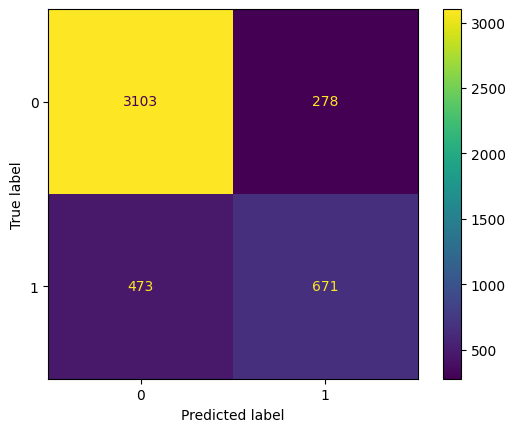

In [542]:
cm_priv_fair = confusion_matrix(y_test_priv, predictions_priv_fair)
disp_priv_fair = ConfusionMatrixDisplay(confusion_matrix=cm_priv_fair)
disp_priv_fair.plot()

Fairness Metric calculated using the real age and sex values


In [544]:
dataset_priv_test_pred = dataset_priv_test.copy(deepcopy=True)
dataset_priv_test_pred.scores = model_priv_fair.predict_proba(X_test_priv)[:, pos_ind].reshape(-1, 1)

fav_inds_priv = dataset_priv_test_pred.scores > threshold_priv_fair
dataset_priv_test_pred.labels[fav_inds_priv] = dataset_priv_test_pred.favorable_label
dataset_priv_test_pred.labels[~fav_inds_priv] = dataset_priv_test_pred.unfavorable_label

eod_priv_fair = ClassificationMetric(
    # dataset_priv_test
    dataset_fair_test
    , dataset_priv_test_pred,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
).equal_opportunity_difference()

print(f'Equal Opportunity Difference (Privacy + Fairness): {eod_priv_fair:.4f}')

Equal Opportunity Difference (Privacy + Fairness): 0.1643


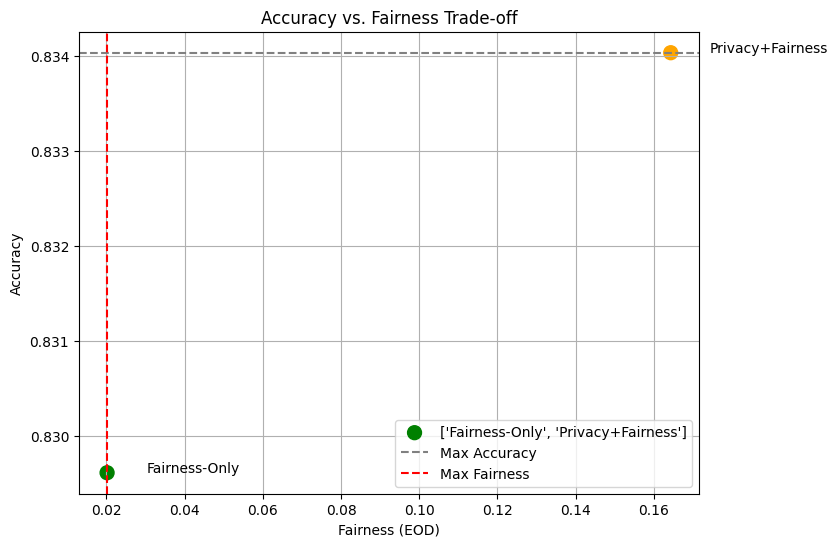

In [545]:
# Example values (replace with actual results)
models = ['Fairness-Only', 'Privacy+Fairness']
# accuracy_met=accuracy
accuracy = [accuracy_fair, accuracy_priv_fair]
fairness = [equal_opportunity_diff_metric, eod_priv_fair]  # EOD values (lower is better)

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(fairness, accuracy, color=['green', 'orange'], s=100, label=models)

# Annotate points
for i, model in enumerate(models):
    plt.text(fairness[i] + 0.01, accuracy[i], model, fontsize=10)

# Labels and title
plt.xlabel('Fairness (EOD)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Fairness Trade-off')
plt.axhline(y=max(accuracy), color='gray', linestyle='--', label='Max Accuracy')
plt.axvline(x=min(fairness), color='red', linestyle='--', label='Max Fairness')
plt.legend()
plt.grid(True)
plt.show()

As expected the accuracy of the fairness only classifier is higher because the model is trained on the unaltered data. On the other hand, adding privacy via the Local Differential Privacy introduces noise to sensitive attributes, which leads to less accurate models because the underlying data quality is degraded. When combined with fairness adjustments, the performance further decreases because these adjustments reduce bias but may also reduce model fit. Moreover, the noise from the privacy mechanisms adds noise to sensitive attributes. 
This noise:

1- Makes it harder to accurately distinguish between privileged and unprivileged groups.

2- Could lead to unintentional oversampling or misclassification of the unprivileged group as privileged during fairness adjustments, or vice versa.

3- If the noise disproportionately affects the privileged group, it may unintentionally boost the TPR for the unprivileged group.

## Explainability

### Global Explainability

In [546]:
# import necessary libraries for explainability
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append("dependencies")

from omnixai.data.tabular import Tabular
from omnixai.preprocessing.tabular import TabularTransform
from omnixai.explainers.tabular import TabularExplainer
import xgboost as xgboost
from itertools import cycle, islice

import pandas as pd
import numpy as np
import sklearn

In [547]:
# ace:  predicts how sensitive the model is to individual feature values
explainers = TabularExplainer(
  explainers=["ale"],                 # The explainers to apply
  mode="classification",                             # The task type
  data=train_data_private,                           # The data for initializing the explainers
  model=model_private,                               # The ML model to explain
  preprocess=lambda z: transformer.transform(z),     # Converts raw features into the model inputs
)

global_explanations = explainers.explain_global()

In [548]:
print("ALE results:")
global_explanations["ale"].ipython_plot(class_names=class_names)

ALE results:


The ALE Explainer isolates one feature at a time and estimates the contribution of the feature value to the outcome

We have one plot for each attribute, where the x-axis shows the different possible values of each attribute and y-axis shows the contribution of the value to the outcome (overall training of the model)

The results are symmetric with one for positive (showing the features that contribute to an outcome of 1) and one for negative (shows features than contribute to an outcome of 0).

From the plots,
Age: aged individuals have more chance to earn a higher income

Workclass: Federal-gov and self-emp-inc have higher chances to earn a higher income than other work classes

Education: Individuals with higher educational value (Doctorate, Professional School, Masters) have more chances to earn higher incomes

and it goes on like that.


### Local Explainability

#### Get instances where the model is wrong but highly confident

In [549]:
# Add confidence scores to the test dataframe
confidence_scores = model_private.predict_proba(test_private).max(axis=1)
test_df_private["confidence"] = confidence_scores

# Identify high-confidence errors
high_confidence_errors = test_df_private[
    (test_df_private["label"] != test_df_private["prediction"]) &
    (test_df_private["confidence"] > 0.98)]

print(f'There are {high_confidence_errors.shape[0]} instances where the model was wrong but had a confidence greater than 0.98')
print("Instances with High-Confidence Errors (> 0.98):")

high_confidence_errors

There are 48 instances where the model was wrong but had a confidence greater than 0.98
Instances with High-Confidence Errors (> 0.98):


,Age,Workclass,Education,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,label,prediction,confidence
96,Aged,Private,HS-grad,Exec-managerial,Not-in-family,White,Male,0.0,0.0,OverTime,United-States,1,0.0,1.000000
363,Aged,Private,Some-college,Exec-managerial,Not-in-family,White,Male,0.0,0.0,OverTime,United-States,1,0.0,1.000000
438,Aged,Private,Bachelors,Sales,Married,White,Female,0.0,0.0,BrainDrain,United-States,0,1.0,0.990000
663,Aged,Private,Bachelors,Sales,Married,White,Female,0.0,0.0,FullTime,United-States,0,1.0,1.000000
664,Aged,Private,Doctorate,Prof-specialty,Married,White,Male,0.0,0.0,BrainDrain,United-States,0,1.0,0.996000
696,Aged,Private,11th,Other-service,Married,Black,Male,0.0,0.0,MidTime,United-States,1,0.0,0.988333
725,Aged,Private,9th,Machine-op-inspct,Married,White,Male,0.0,0.0,FullTime,United-States,1,0.0,0.997500
993,Young,Private,Assoc-voc,Craft-repair,Own-child,White,Male,0.0,0.0,FullTime,United-States,1,0.0,0.995500
1042,Young,Private,Some-college,Exec-managerial,Not-in-family,White,Male,0.0,0.0,OverTime,United-States,1,0.0,1.000000
1144,Young,Private,Masters,Prof-specialty,Married,White,Female,0.0,0.0,OverTime,United-States,0,1.0,0.984167


In [550]:
high_conf_idx = high_confidence_errors.index
high_conf_idx

Index([  96,  363,  438,  663,  664,  696,  725,  993, 1042, 1144, 1317, 1369,
       1581, 1605, 1621, 1889, 1912, 1970, 2004, 2006, 2029, 2034, 2053, 2146,
       2151, 2337, 2447, 2461, 2511, 2642, 2810, 2862, 2877, 2927, 2969, 3008,
       3533, 3762, 3787, 3909, 3977, 4099, 4109, 4150, 4206, 4376, 4378, 4404],
      dtype='int64')

In [551]:
explainers = TabularExplainer(
  explainers=['lime', 'mace'],                       # The explainers to apply
  mode="classification",                             # The task type
  data=train_data_private,                           # The data for initializing the explainers
  model=model_private,                               # The ML model to explain
  preprocess=lambda z: transformer.transform(z),     # Converts raw features into the model inputs
  params={
        "mace": {"ignored_features": ["Sex", "Race"]}# params which cannot change when creating counterfactuals
    }
)

# analysing instances
instance_ids = [96, 663, 696, 1144]
comments = [
    "incorrect prediction for true label=1, and the model is 100% confident",
    "incorrect prediction for true label=0, and the model is 100% confident",
    "incorrect prediction for true label=1, and the model is highly confident",
    "incorrect prediction for true label=0, and the model is highly confident"
]

n_instances = len(instance_ids)

test_instances = test_data_private[instance_ids]
local_explanations = explainers.explain(X=test_instances)

In [552]:
print("LIME results:")

for i, instance_id in enumerate(instance_ids):
    print(comments[i])
    print(f"Instance {instance_id} has label {test_labels_private[instance_id]} and prediction {predictions_private[instance_id]}, with probs {model_private.predict_proba(test_private[instance_id:instance_id+1])[0]}")
    local_explanations["lime"].ipython_plot(index=i, class_names=class_names)
    print('-./'*50)
    print('\n')

LIME results:
incorrect prediction for true label=1, and the model is 100% confident
Instance 96 has label 1 and prediction 0.0, with probs [1. 0.]


-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./


incorrect prediction for true label=0, and the model is 100% confident
Instance 663 has label 0 and prediction 1.0, with probs [0. 1.]


-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./


incorrect prediction for true label=1, and the model is highly confident
Instance 696 has label 1 and prediction 0.0, with probs [0.98833333 0.01166667]


-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./


incorrect prediction for true label=0, and the model is highly confident
Instance 1144 has label 0 and prediction 1.0, with probs [0.01583333 0.98416667]


-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./-./




In [553]:
print("MACE results:")


for expl_id, instance_id in enumerate(instance_ids):
    
    query_df = local_explanations['mace'].get_explanations()[expl_id]['query'].reset_index(drop=True)
    query_df.index = [f"{instance_id}"] * len(query_df)
    # display(query_df)


    counter_df = local_explanations['mace'].get_explanations()[expl_id]['counterfactual'].reset_index(drop=True)
    counter_df.index = [ f"CF[{cnt}] for {instance_id}" for cnt in range(len(counter_df))]
    # display(counter_df)

    combined_df = pd.concat([query_df, counter_df])


    # Highlighting function
    def highlight_changes(row):
        instance_row = combined_df.iloc[0]  # Reference row for the instance
        return ["color: red" if row[col] != instance_row[col] else "" for col in combined_df.columns]

    # Apply the style
    styled_df = combined_df.style.apply(highlight_changes, axis=1)
    
    # Display the styled dataframe
    display(styled_df) 



MACE results:


,Age,Workclass,Education,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,label
96,Aged,Private,HS-grad,Exec-managerial,Not-in-family,White,Male,0.000000,0.000000,OverTime,United-States,0
CF[0] for 96,Aged,Private,Prof-school,Exec-managerial,Married,White,Male,0.000000,0.000000,OverTime,United-States,1
CF[1] for 96,Aged,Private,HS-grad,Tech-support,Married,White,Male,0.000000,0.000000,OverTime,United-States,1
CF[2] for 96,Aged,Private,HS-grad,Exec-managerial,Married,White,Male,0.000000,0.000000,FullTime,United-States,1
CF[3] for 96,Aged,Self-emp-not-inc,HS-grad,Exec-managerial,Not-in-family,White,Male,0.000000,2559.000000,OverTime,United-States,1
CF[4] for 96,Aged,Private,HS-grad,Exec-managerial,Not-in-family,White,Male,7232.500000,0.000000,OverTime,United-States,1


,Age,Workclass,Education,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,label
663,Aged,Private,Bachelors,Sales,Married,White,Female,0.000000,0.000000,FullTime,United-States,1
CF[0] for 663,Aged,Private,Bachelors,Craft-repair,Married,White,Female,0.000000,0.000000,FullTime,United-States,0
CF[1] for 663,Aged,Private,9th,Sales,Married,White,Female,0.000000,0.000000,FullTime,United-States,0
CF[2] for 663,Aged,Private,Bachelors,Other-service,Not-in-family,White,Female,0.000000,0.000000,FullTime,United-States,0
CF[3] for 663,Aged,Private,9th,Sales,Married,White,Female,0.000000,0.000000,OverTime,United-States,0
CF[4] for 663,Aged,Private,10th,Craft-repair,Married,White,Female,0.000000,0.000000,FullTime,United-States,0


,Age,Workclass,Education,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,label
696,Aged,Private,11th,Other-service,Married,Black,Male,0.000000,0.000000,MidTime,United-States,0
CF[0] for 696,Aged,Private,Masters,Other-service,Married,Black,Male,0.000000,0.000000,BrainDrain,United-States,1
CF[1] for 696,Aged,Private,Masters,Sales,Married,Black,Male,0.000000,0.000000,MidTime,United-States,1
CF[2] for 696,Aged,Private,Bachelors,Craft-repair,Married,Black,Male,0.000000,0.000000,FullTime,United-States,1
CF[3] for 696,Aged,Private,11th,Other-service,Married,Black,Male,0.000000,1902.000000,FullTime,United-States,1
CF[4] for 696,Aged,Private,11th,Prof-specialty,Married,Black,Male,0.000000,1902.000000,MidTime,United-States,1


,Age,Workclass,Education,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,label
1144,Young,Private,Masters,Prof-specialty,Married,White,Female,0.000000,0.000000,OverTime,United-States,1
CF[0] for 1144,Young,Private,Masters,Prof-specialty,Not-in-family,White,Female,0.000000,0.000000,OverTime,United-States,0
CF[1] for 1144,Young,Local-gov,Masters,Prof-specialty,Unmarried,White,Female,0.000000,0.000000,OverTime,United-States,0
CF[2] for 1144,Young,Local-gov,Masters,Machine-op-inspct,Married,White,Female,0.000000,0.000000,OverTime,United-States,0
CF[3] for 1144,Young,Private,Masters,Machine-op-inspct,Not-in-family,White,Female,0.000000,0.000000,OverTime,United-States,0
CF[4] for 1144,Young,Private,Masters,Machine-op-inspct,Married,White,Female,0.000000,0.000000,PartTime,United-States,0


Changing the values of the attributes in red will change the label

### Investigate Noisy Values 

To investiate the noisy values, we will compare the predictions from the private classifier to the predictions of the original classifier where the Age and Sex columns changed. 

If the noisy values for these attributes lead to a change in the prediction, we can conclude that the noisy values are responsible for the model being confident and wrong 


In [554]:
# Compare original and noisy attributes for misclassified instances
original_sensitive = test_df.iloc[high_conf_idx][['Age', 'Sex', 'prediction', 'label']]
noisy_sensitive = high_confidence_errors[['Age', 'Sex', 'prediction', 'confidence']]
noisy_sensitive.rename(columns={'prediction': 'prediction_private', 'Age':'Age_private', 'Sex':'Sex_private'}, inplace=True)

In [555]:
# Analyze differences
sensitive_comparison = pd.concat([original_sensitive, noisy_sensitive], axis=1)
print("Comparison of original vs. noisy sensitive attributes for high confidence errors:")
sensitive_comparison

Comparison of original vs. noisy sensitive attributes for high confidence errors:


,Age,Sex,prediction,label,Age_private,Sex_private,prediction_private,confidence
96,Aged,Male,0.0,1,Aged,Male,0.0,1.000000
363,Young,Female,0.0,1,Aged,Male,0.0,1.000000
438,Aged,Male,1.0,0,Aged,Female,1.0,0.990000
663,Young,Male,1.0,0,Aged,Female,1.0,1.000000
664,Aged,Male,1.0,0,Aged,Male,1.0,0.996000
696,Aged,Female,0.0,1,Aged,Male,0.0,0.988333
725,Aged,Female,0.0,1,Aged,Male,0.0,0.997500
993,Young,Male,0.0,1,Young,Male,0.0,0.995500
1042,Aged,Male,0.0,1,Young,Male,0.0,1.000000
1144,Aged,Male,1.0,0,Young,Female,1.0,0.984167


In [556]:
# get instances where noisy values occur
noisy_values = sensitive_comparison[(sensitive_comparison['Age'] != sensitive_comparison['Age_private']) | (sensitive_comparison['Sex'] != sensitive_comparison['Sex_private'])]
print(f'There are {noisy_values.shape[0]} instances where noisy values occur in the test data')
noisy_values

There are 23 instances where noisy values occur in the test data


,Age,Sex,prediction,label,Age_private,Sex_private,prediction_private,confidence
363,Young,Female,0.0,1,Aged,Male,0.0,1.000000
438,Aged,Male,1.0,0,Aged,Female,1.0,0.990000
663,Young,Male,1.0,0,Aged,Female,1.0,1.000000
696,Aged,Female,0.0,1,Aged,Male,0.0,0.988333
725,Aged,Female,0.0,1,Aged,Male,0.0,0.997500
1042,Aged,Male,0.0,1,Young,Male,0.0,1.000000
1144,Aged,Male,1.0,0,Young,Female,1.0,0.984167
1317,Young,Male,0.0,1,Aged,Female,0.0,0.982500
1369,Aged,Female,0.0,1,Young,Female,0.0,0.996071
1889,Young,Male,0.0,1,Young,Female,0.0,0.990000


In [557]:
# get instances where the predictions for the private classifier and original classifier are different
diff_pred = noisy_values[noisy_values['prediction'] != noisy_values['prediction_private']]
print(f'There is {diff_pred.shape[0]} instance where the predictions using the private classifier differs from the original classifier')
diff_pred 

There is 1 instance where the predictions using the private classifier differs from the original classifier


,Age,Sex,prediction,label,Age_private,Sex_private,prediction_private,confidence
2969,Young,Male,0.0,0,Aged,Male,1.0,0.99


Since there is only one instance where the predictions using the private classifier differ from the original classifier, we can conclude that the noisy values for Sex and Age are not responsible for the model being confident and wrong since they mostly return the same predicted value.

#### Investigating with a Reduced Confidence Threshold > 0.90

In [558]:
# Identify high-confidence errors greater than 0.90
high_confidence_errors_90 = test_df_private[
    (test_df_private["label"] != test_df_private["prediction"]) &
    (test_df_private["confidence"] > 0.90)]

print(f'There are {high_confidence_errors_90.shape[0]} instances where the model was wrong but had a confidence greater than 0.98')

high_conf_idx_90 = high_confidence_errors_90.index

# Compare original and noisy attributes for misclassified instances
original_sensitive_90 = test_df.iloc[high_conf_idx_90][['Age', 'Sex', 'prediction', 'label']]
noisy_sensitive_90 = high_confidence_errors_90[['Age', 'Sex', 'prediction', 'confidence']]
noisy_sensitive_90.rename(columns={'prediction': 'prediction_private', 'Age':'Age_private', 'Sex':'Sex_private'}, inplace=True)

# Analyze differences
sensitive_comparison_90 = pd.concat([original_sensitive_90, noisy_sensitive_90], axis=1)
print("Comparison of original vs. noisy sensitive attributes for high confidence errors:")
sensitive_comparison_90.head()

There are 118 instances where the model was wrong but had a confidence greater than 0.98
Comparison of original vs. noisy sensitive attributes for high confidence errors:


,Age,Sex,prediction,label,Age_private,Sex_private,prediction_private,confidence
34,Aged,Male,0.0,1,Aged,Female,0.0,0.973333
96,Aged,Male,0.0,1,Aged,Male,0.0,1.000000
119,Young,Male,1.0,0,Aged,Female,1.0,0.949905
125,Aged,Male,1.0,0,Aged,Male,1.0,0.916667
161,Aged,Female,0.0,1,Aged,Female,0.0,0.915287


In [559]:
# get instances where noisy values occur
noisy_values_90 = sensitive_comparison_90[(sensitive_comparison_90['Age'] != sensitive_comparison_90['Age_private'])
            | (sensitive_comparison_90['Sex'] != sensitive_comparison_90['Sex_private'])]
print(f'There are {noisy_values_90.shape[0]} instances where noisy values occur in the test data')

# get instances where the predictions for the private classifier and original classifier are different
diff_pred_90 = noisy_values_90[noisy_values_90['prediction'] != noisy_values_90['prediction_private']]
print(f'There are {diff_pred_90.shape[0]} instances where the predictions using the private classifier differs from the original classifier')
diff_pred_90

There are 58 instances where noisy values occur in the test data
There are 2 instances where the predictions using the private classifier differs from the original classifier


,Age,Sex,prediction,label,Age_private,Sex_private,prediction_private,confidence
528,Young,Male,0.0,0,Aged,Male,1.0,0.902237
2969,Young,Male,0.0,0,Aged,Male,1.0,0.990000


Since there are only two instances where the predictions using the private classifier differ from the original classifier, we can conclude that the noisy values for Sex and Age are not significantly responsible for the model being confident and wrong since they mostly return the same predicted value.

### Explainability and LLMs
create a natural language interface with SHAP explainability method

In [560]:
import shap
import requests
import pandas as pd
import numpy as np

# Select test sample index
test_index = 0  # Change this value to select a specific sample
print(f"Selected Test Sample Index: {test_index}")

# SHAP Explanation Section
try:
    # Use the transformed test sample
    test_sample_transformed = test_private[test_index:test_index + 1]

    # Convert transformed data to a DataFrame with column names
    transformed_feature_names = transformer_private.get_feature_names()  # Use correct function from transformer
    test_sample_transformed_df = pd.DataFrame(test_sample_transformed, columns=transformed_feature_names)
    print("\nTransformed Test Sample (Input to Model):")
    print(test_sample_transformed_df)

    # Generate SHAP values using TreeExplainer
    shap_explainer = shap.TreeExplainer(model_private)
    shap_values = shap_explainer.shap_values(test_sample_transformed_df)
    print("\nSHAP Values Generated Successfully.")

    # Dynamically aggregate SHAP values based on original feature prefixes
    shap_aggregated = {}
    for feature in ["Age", "Workclass", "Education", "Occupation", "Relationship", "Race", "Sex", "Capital Gain",
                    "Capital Loss", "Hours per week", "Country"]:  # Adjust this list to include all original features
        # Identify columns related to this original feature
        related_columns = [col for col in transformed_feature_names if col.startswith(feature)]
        shap_aggregated[feature] = sum(
            shap_values[1][0][i] for i, col in enumerate(transformed_feature_names) if col in related_columns
        )

    # Display aggregated SHAP values
    print("\nAggregated SHAP Values (Mapped to Original Features):")
    for feature, importance in shap_aggregated.items():
        print(f"{feature}: {importance:.2f}")

except Exception as e:
    print(f"Error generating SHAP explanation: {e}")
    shap_aggregated = {}

# Natural Language Explanation Section
try:
    # Function to generate natural language explanations
    def generate_explanation(feature_importances):
        feature_str = "\n".join([f"{feature}: {importance:.2f}" for feature, importance in feature_importances.items()])
        prompt = f"""
        Based on the following feature SHAP values:
        {feature_str}
        Explain the SHAP values for the prediction of whether an individual earns more than $50,000 per year. 
        Each SHAP value represents the contribution of a feature to the prediction relative to a baseline probability. 
        For each feature: Indicate whether it increases or decreases the likelihood of earning more than $50,000.
        Avoid percentages or unsupported assumptions. Be concise and clear."""
        url = "http://localhost:1337/v1/chat/completions"  
        headers = {
            "Content-Type": "application/json",
            "Authorization": "api_key",  # Replace
        }
        payload = {
            "messages": [
                {"role": "system", "content": "You are an assistant that explains model predictions based on these SHAP values."},
                {"role": "user", "content": prompt},
            ],
            "model": "llama3.2-1b-instruct",  
            "max_tokens": 700,
            "temperature": 0.2,
            "top_p": 0.95,
        }
        response = requests.post(url, headers=headers, json=payload)
        if response.status_code == 200:
            return response.json()["choices"][0]["message"]["content"]
        else:
            return f"Error: {response.status_code}, {response.text}"

    # Check if SHAP values were successfully generated
    if shap_aggregated:
        explanation_text = generate_explanation(shap_aggregated)
        print("\nGenerated Natural Language Explanation:")
        print(explanation_text)
    else:
        print("SHAP explanation failed; skipping natural language explanation.")
except Exception as e:
    print(f"Error generating natural language explanation: {e}")


Selected Test Sample Index: 0

Transformed Test Sample (Input to Model):
   Age_Aged  Age_Young  Workclass_Federal-gov  Workclass_Local-gov  \
0       1.0        0.0                    0.0                  0.0   

   Workclass_Private  Workclass_Self-emp-inc  Workclass_Self-emp-not-inc  \
0                1.0                     0.0                         0.0   

   Workclass_State-gov  Workclass_Without-pay  Education_10th  ...  \
0                  0.0                    0.0             0.0  ...   

   Country_Scotland  Country_South  Country_Taiwan  Country_Thailand  \
0               0.0            0.0             0.0               0.0   

   Country_Trinadad&Tobago  Country_United-States  Country_Vietnam  \
0                      0.0                    1.0              0.0   

   Country_Yugoslavia  Capital Gain  Capital Loss  
0                 0.0           0.0           0.0  

[1 rows x 99 columns]

SHAP Values Generated Successfully.
Error generating SHAP explanation: index 1